### SETUP

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer
import librosa
import datetime
import os

2024-05-15 14:50:59.997028: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-15 14:50:59.997135: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-15 14:50:59.998404: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-15 14:51:00.006532: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-15 14:51:00.921085: W tensorflow/compiler/tf2

### Load the Holy-Quran Dataset

In [2]:
abs_path = os.path.abspath('')
data_path = abs_path + "/data"
wavs_path = data_path + "/audio112114/"
metadata_path = data_path + "/transcription_phonem112114.csv"


# Read metadata file and parse it
metadata_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)
metadata_df.columns = ["file_name", "phonem"]
metadata_df = metadata_df[["file_name", "phonem"]]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
metadata_df.head(3)

,file_name,phonem
0,114002_22,maliki naa:si
1,114001_10,qul ʔaʕuwðu birabi naa:si
2,113002_22,min ʃari maa: xalaqa


In [3]:
split = int(len(metadata_df) * .9)
df_train = metadata_df[:split]
df_val = metadata_df[split:]

print(f"Size of the training set: {len(df_train)}")
print(f"Size of the validation set: {len(df_val)}")

Size of the training set: 140
Size of the validation set: 16


### Preprocess the Data

In [4]:
# The set of characters accepted in the transcription.
characters = [x for x in "tljˤʒkʃθʔabnu: zwʕmqɣfrsxiðħdh"]
# Mapping characters to integers
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
# Mapping integers back to original characters
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 't', 'l', 'j', 'ˤ', 'ʒ', 'k', 'ʃ', 'θ', 'ʔ', 'a', 'b', 'n', 'u', ':', ' ', 'z', 'w', 'ʕ', 'm', 'q', 'ɣ', 'f', 'r', 's', 'x', 'i', 'ð', 'ħ', 'd', 'h'] (size =31)


2024-05-15 14:51:02.520876: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-15 14:51:02.564263: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-15 14:51:02.564333: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-15 14:51:02.569197: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-15 14:51:02.569285: I external/local_xla/xla/stream_executor

In [39]:
# An integer scalar Tensor. The window length in samples.
frame_length = 256
# An integer scalar Tensor. The number of samples to step.
frame_step = 160
# An integer scalar Tensor. The size of the FFT to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
fft_length = 384
# The number of Mel frequency bins.
num_mel_bins = 10  # You can adjust this according to your needs
# sample_rate = 22050.0
# sample_rate = tf.cast(sample_rate, dtype=tf.float32)

In [6]:
def encode_single_sample(wav_file, label):
    ###########################################
    # Process the Audio
    ##########################################
    # 1. Read wav file
    file = tf.io.read_file(wavs_path + wav_file + ".wav")
    # 2. Decode the wav file
    audio, _ = tf.audio.decode_wav(file, desired_channels=1)
    audio = tf.squeeze(audio, axis=-1)
    # 3. Change type to float
    audio = tf.cast(audio, tf.float32)
    # 4. Get the spectrogram
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    # 5. We only need the magnitude, which can be derived by applying tf.abs
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    # 6. normalisation
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)
    ###########################################
    # Process the label
    ##########################################
    # 7. Convert label to Lower case
    label = tf.strings.lower(label)
    # 8. Split the label
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    # 9. Map the characters in label to numbers
    label = char_to_num(label)
    # 10. Return a dict as our model is expecting two inputs
    return spectrogram, label

In [60]:
@tf.function
def encode_single_sample_mel(wav_file, label):
    ###########################################
    # Process the Audio
    ##########################################
    # 1. Read wav file
    file = tf.io.read_file(wavs_path + wav_file + ".wav")
    # 2. Decode the wav file
    audio, sample_rate = tf.audio.decode_wav(file, desired_channels=1)
    audio = tf.squeeze(audio, axis=1)
    # 3. Change type to float
    audio = tf.cast(audio, tf.float32)
    # sample_rate = tf.cast(sample_rate, tf.float32)    
    # 4. Get the spectrogram
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    spectrogram = tf.abs(spectrogram)
    num_spectrogram_bins = spectrogram.shape[-1]
    # num_spectrogram_bins = tf.cast(num_spectrogram_bins, dtype=tf.float32)
    # 5. Create mel filter
    # lowest_freq = 20.0
    # high_freq = sample_rate / 2
    mel_filter = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins, num_spectrogram_bins, sample_rate
    )
    # 6. Apply the filter to the spectrogram
    mel_spectrogram = tf.tensordot(spectrogram, mel_filter, 1)
    # 7. Convert to db
    mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)
    # 8. normalisation
    means = tf.math.reduce_mean(mel_spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(mel_spectrogram, 1, keepdims=True)
    mel_spectrogram = (mel_spectrogram - means) / (stddevs + 1e-10)    
    ###########################################
    # Process the label
    ##########################################
    # 9. Convert label to Lower case
    label = tf.strings.lower(label)
    # 10. Split the label
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    # 11. Map the characters in label to numbers
    label = char_to_num(label)
    # 12. Return a dict as our model is expecting two inputs
    return mel_spectrogram, label


In [61]:
for i in range(2):
    print(i)
    print(encode_single_sample_mel(df_train["file_name"].iloc[i], df_train["phonem"].iloc[i]))

0
(<tf.Tensor: shape=(661, 10), dtype=float32, numpy=
array([[ 0.60310173,  0.7237556 ,  0.8004026 , ..., -0.4073347 ,
        -0.9166691 , -2.0093114 ],
       [-0.6366751 , -0.454189  ,  2.0040581 , ..., -0.5450844 ,
        -0.73993623, -1.1635438 ],
       [ 0.1789016 ,  0.23159361, -0.40032053, ..., -0.63448745,
         0.5977586 , -2.32044   ],
       ...,
       [ 1.0789101 ,  1.333153  ,  1.3046278 , ..., -1.3400666 ,
        -0.61764336, -1.3612145 ],
       [ 1.1862224 ,  1.5927786 ,  0.74119675, ..., -1.6061808 ,
        -0.7913852 , -1.126415  ],
       [ 1.2972    ,  1.462126  ,  0.13130188, ..., -1.2748287 ,
        -1.1366326 , -1.3963507 ]], dtype=float32)>, <tf.Tensor: shape=(13,), dtype=int64, numpy=array([19, 10,  2, 26,  6, 26, 15, 12, 10, 10, 14, 24, 26])>)
1
(<tf.Tensor: shape=(841, 10), dtype=float32, numpy=
array([[ 0.668633  ,  1.0751278 ,  0.6367216 , ..., -0.53384984,
         0.15671274,  0.87162876],
       [-0.5349581 , -1.6991326 ,  0.09159112, ...,  0.3

### Creating Dataset Objects

In [62]:
batch_size = 4
# Define the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["file_name"]), list(df_train["phonem"]))
)
train_dataset = (
    train_dataset.map(encode_single_sample_mel, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_name"]), list(df_val["phonem"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample_mel, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

Sample rate seharusnya: 22050


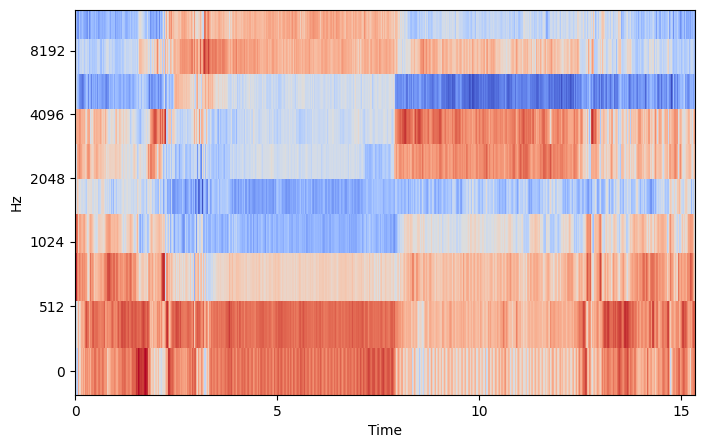

In [63]:
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    mel_spectrogram = batch[0][0].numpy()
    mel_spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(mel_spectrogram)])
    label = batch[1][0]
    # mel mel_Spectrogram
    # label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    # ax = plt.subplot(2, 1, 1)
    # ax.imshow(mel_spectrogram, vmax=1)
    # ax.set_title(label)
    # ax.axis("off")
    # Wav
    file = tf.io.read_file(wavs_path + list(df_train["file_name"])[0] + ".wav")
    audio, sr = tf.audio.decode_wav(file)
    sr = sr.numpy()
    librosa.display.specshow(mel_spectrogram, sr=sr, x_axis="time", y_axis="mel")
    print(f"Sample rate seharusnya: {sr}")
    audio = audio.numpy()
    # ax = plt.subplot(2, 1, 2)
    # plt.plot(audio)
    # ax.set_title("Signal Wave")
    # ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=sr))
plt.show()

### Model

In [12]:
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [13]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    """Model similar to DeepSpeech2."""
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input")
    # Expand the dimension to use 2D CNN.
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    # Convolution layer 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    # Convolution layer 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    # Reshape the resulted volume to feed the RNNs layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    # RNN layers
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)
    # Dense layer
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)
    # Classification layer
    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)
    # Model
    model = tf.keras.Model(input_spectrogram, output, name="DeepSpeech_2")
    # Optimizer
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4)
    # Compile the model and return
    model.compile(optimizer=opt, loss=CTCLoss)
    return model

In [14]:
# Get the model
model = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
)
model.summary(line_length=110)

Model: "DeepSpeech_2"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input (InputLayer)                              [(None, None, 193)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 193, 1)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 97, 32)                        14432            
                                                                                                              
 conv_1_bn (BatchNormalization)                  (None, None, 97, 32)                     

### Training and Evaluating

In [12]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)

In [13]:
# Define the number of epochs.
epochs = 100
# Define the log directory for tensorboard
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=50, restore_best_weights=True
)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "model.h5", monitor="val_loss", save_best_only=True
)
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback, 
            tensorboard_callback,
            early_stopping, 
            checkpoint],
)

Epoch 1/100


2024-04-29 01:18:36.246803: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-04-29 01:18:40.115927: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-29 01:18:41.040578: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.96GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-29 01:18:41.423953: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.96GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


 1/35 [..............................] - ETA: 17:52 - loss: 1672.3127

2024-04-29 01:18:50.759292: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-29 01:18:51.145973: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


 2/35 [>.............................] - ETA: 3:11 - loss: 1522.3356 

2024-04-29 01:18:56.575865: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.91GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-29 01:18:56.941519: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.91GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


 3/35 [=>............................] - ETA: 3:09 - loss: 1250.2401

2024-04-29 01:19:02.644457: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.98GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-29 01:19:03.014522: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.98GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


 4/35 [==>...........................] - ETA: 3:04 - loss: 1207.0765

2024-04-29 01:19:08.688002: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.99GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-29 01:19:09.094733: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.99GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1/1 [==============================] - 0s 443ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Target    : wamin ʃari ɣaa:siqin ʔiðaa: waqaba
Prediction: i
----------------------------------------------------------------------------------------------------
Target    : qul ʔaʕuwðu birabi lfalaqi
Prediction: i
----------------------------------------------------------------------------------------------------


/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


35/35 [==============================] - 300s 8s/step - loss: 505.7741 - val_loss: 291.8124
Epoch 2/100
1/1 [==============================] - 1s 666ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Target    : wamin ʃari ɣaa:siqin ʔiðaa: waqaba
Prediction: 
----------------------------------------------------------------------------------------------------
Target    : qul ʔaʕuwðu birabi lfalaqi
Prediction: 
----------------------------------------------------------------------------------------------------
35/35 [==============================] - 74s 2s/step - loss: 226.3083 - val_loss: 135.3524
Epoch 3/100
1/1 [==============================] - 1s 865ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------

### Inference

In [14]:
def decode_batch_prediction_without_ctc(pred):
    results = tf.argmax(pred, axis=2)
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

In [19]:
# Let's check results on more validation samples
predictions = []
predictions_no_ctc = []
targets = []
for batch in validation_dataset:
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions_no_ctc = decode_batch_prediction_without_ctc(batch_predictions)
    batch_predictions_ctc = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions_ctc)
    predictions_no_ctc.extend(batch_predictions_no_ctc)
        
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print(f"Prediction without CTC: {predictions_no_ctc[i]}")
    print("-" * 100)

1/1 [==============================] - 0s 397ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.6912
----------------------------------------------------------------------------------------------------
Target    : wamin ʃari nafaa:θaa:ti fij lʕuqadi
Prediction: wamin ʃari nafa:θa:ti fij lʕuqad
Prediction without CTC: wwaaminn  ʃaarri   nnaaafaaaaaa::θθθaa::tii   ffiijj  lllʕʕuuuqqaadd
----------------------------------------------------------------------------------------------------
Target    : qul ʔaʕuwðu birabi naa:si
Prediction: qul ʔaʕuwðu bira na:si
Prediction without CTC: quulll  ʔaaaʕʕuwwððuu bbira  nnaaaaaaa::ssiii
----------------------------------------------------------------------------------------------------
Target    : wamin ʃari ɣaa:siqin ʔiðaa: waqaba
Prediction: wamin ʃariuwa:si ma waqa
Prediction without CTC: wwaamminnn   ʃʃaarriiuuuwwwwaaaa:sssiiii  mmaaaa  waaqqaa
------------------------